# Proširenje

In [3]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Loading data
df_assessments = pd.read_csv('assessments.csv')
df_courses = pd.read_csv('courses.csv')
df_studentAssessment = pd.read_csv('studentAssessment.csv')
df_studentInfo = pd.read_csv('studentInfo.csv')
df_studentRegistration = pd.read_csv('studentRegistration.csv')
df_studentVle = pd.read_csv('studentVle.csv')
df_vle = pd.read_csv('vle.csv')

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Dropout prediction

## Feature extraction & Preprocessing

In [6]:
df_dropout = df_studentInfo[['code_module', 'code_presentation', 'id_student', 'final_result']]
df_dropout['final_result'].replace({'Pass':0, 'Fail':0, 'Distinction':0, 'Withdrawn':1}, inplace=True)
# DF sa svim student-predmet kombinacijama i njihov final result; 1->dropout, 0->not dropout
df_dropout

,code_module,code_presentation,id_student,final_result
0,AAA,2013J,11391,0
1,AAA,2013J,28400,0
2,AAA,2013J,30268,1
3,AAA,2013J,31604,0
4,AAA,2013J,32885,0
...,...,...,...,...
32588,GGG,2014J,2640965,0
32589,GGG,2014J,2645731,0
32590,GGG,2014J,2648187,0
32591,GGG,2014J,2679821,1


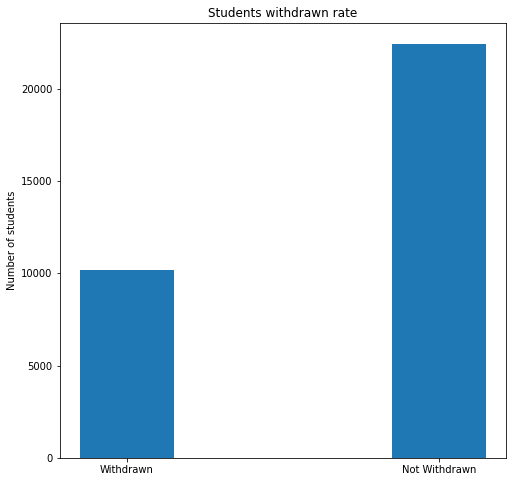

In [7]:
graph_data = {'Withdrawn':len(df_dropout[df_dropout['final_result'] == 1]), 'Not Withdrawn':len(df_dropout[df_dropout['final_result'] == 0])}
graph_data
fig = plt.figure(figsize=(8, 8))
plt.bar(list(graph_data.keys()), list(graph_data.values()), width=0.3)
plt.ylabel("Number of students")
plt.title("Students withdrawn rate")
plt.show()

In [8]:
print("Dropout rate is "+str(round(len(df_dropout[df_dropout['final_result'] == 1])/len(df_dropout), 5)))
print("Our model needs to have accuracy > "+str(1-0.3116))

Dropout rate is 0.3116
Our model needs to have accuracy > 0.6884


In [9]:
df_stud_demographic = pd.get_dummies(df_studentInfo, columns=['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability'], drop_first=True)
df_stud_demographic['final_result'].replace({'Pass':0, 'Fail':0, 'Distinction':0, 'Withdrawn':1}, inplace=True)
# DF sa demografskin znacajkama studenata
df_stud_demographic

,code_module,code_presentation,id_student,num_of_prev_attempts,studied_credits,final_result,gender_M,region_East Midlands Region,region_Ireland,region_London Region,...,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_35-55,age_band_55<=,disability_Y
0,AAA,2013J,11391,0,240,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,AAA,2013J,28400,0,60,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,AAA,2013J,30268,0,60,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,AAA,2013J,31604,0,60,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,AAA,2013J,32885,0,60,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,0,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32589,GGG,2014J,2645731,0,30,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
32590,GGG,2014J,2648187,0,30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32591,GGG,2014J,2679821,0,30,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [10]:
df_stud_Assessment = df_studentAssessment.merge(df_assessments.drop(['date', 'weight'], axis=1), how='left', on=['id_assessment'])
df_stud_Assessment = df_stud_Assessment[df_stud_Assessment['assessment_type'] != 'Exam']
df_stud_Assessment = pd.get_dummies(df_stud_Assessment, columns=['assessment_type'], drop_first=True).drop(['is_banked'], axis=1)
df_stud_Assessment = df_stud_Assessment.drop(['id_assessment', 'date_submitted'], axis=1).groupby(['id_student', 'code_module', 'code_presentation', 'assessment_type_TMA']).mean().reset_index()
df_stud_Assessment = df_stud_Assessment.set_index(['code_module', 'code_presentation', 'id_student', 'assessment_type_TMA']).unstack(['assessment_type_TMA'])
df_stud_Assessment.columns = ['{}_{}'.format(t, v) for v, t in df_stud_Assessment.columns]
df_stud_Assessment = df_stud_Assessment.reset_index()
df_stud_Assessment = df_stud_Assessment.fillna(0)
df_stud_Assessment = df_stud_Assessment.merge(df_dropout, how='right', on=['code_module', 'code_presentation', 'id_student'])
df_stud_Assessment = df_stud_Assessment.fillna(0)
# DF sa avg score svakog studenta za dvije razlicite vrse assessmenta
#1_score -> TMA score
#0_score -> CMA score
df_stud_Assessment

,code_module,code_presentation,id_student,0_score,1_score,final_result
0,AAA,2013J,11391,0.000000,82.000000,0
1,AAA,2013J,28400,0.000000,66.400000,0
2,AAA,2013J,30268,0.000000,0.000000,1
3,AAA,2013J,31604,0.000000,76.000000,0
4,AAA,2013J,32885,0.000000,54.400000,0
...,...,...,...,...,...,...
32588,GGG,2014J,2640965,0.000000,0.000000,0
32589,GGG,2014J,2645731,93.333333,77.666667,0
32590,GGG,2014J,2648187,80.000000,70.000000,0
32591,GGG,2014J,2679821,100.000000,83.000000,1


<AxesSubplot:ylabel='Frequency'>

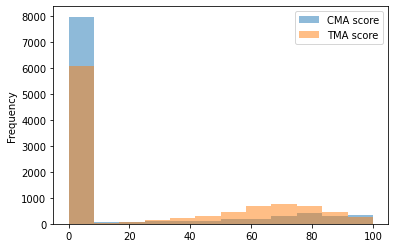

In [11]:
df_barplot = df_stud_Assessment[df_stud_Assessment['final_result']==1]
df_barplot = df_barplot.rename(columns={'0_score':'CMA score', '1_score':'TMA score'})
df_barplot[['CMA score', 'TMA score']].plot.hist(bins=12, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

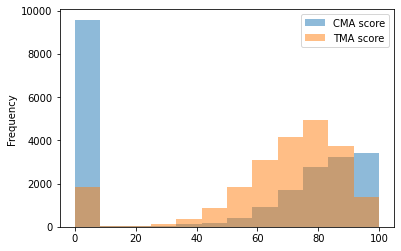

In [9]:
df_barplot = df_stud_Assessment[df_stud_Assessment['final_result']==0]
df_barplot = df_barplot.rename(columns={'0_score':'CMA score', '1_score':'TMA score'})
df_barplot[['CMA score', 'TMA score']].plot.hist(bins=12, alpha=0.5)

In [12]:
df_activity_sum = df_studentVle.drop(['date'], axis=1).merge(df_vle.drop(['week_from', 'week_to'], axis=1), how='left', on=['id_site', 'code_module', 'code_presentation'])
df_activity_sum = df_activity_sum.drop(['id_site'], axis=1)
df_activity_sum = df_activity_sum.groupby(['code_module', 'code_presentation', 'id_student', 'activity_type']).sum()
df_activity_sum = df_activity_sum.reset_index()
df_activity_sum = df_activity_sum.set_index(['code_module', 'code_presentation', 'id_student', 'activity_type']).unstack(['activity_type'])
df_activity_sum.columns = ['{}_{}'.format(t, v) for v, t in df_activity_sum.columns]
df_activity_sum = df_activity_sum.reset_index()
df_activity_sum = df_activity_sum.fillna(0)
df_activity_sum = df_activity_sum.merge(df_dropout, how='right', on=['code_module', 'code_presentation', 'id_student'])
df_activity_sum = df_activity_sum.fillna(0)
# DF sa sumom klikova po aktivnostima za svakog studenta i predmete
df_activity_sum

,code_module,code_presentation,id_student,dataplus_sum_click,dualpane_sum_click,externalquiz_sum_click,folder_sum_click,forumng_sum_click,glossary_sum_click,homepage_sum_click,...,ouwiki_sum_click,page_sum_click,questionnaire_sum_click,quiz_sum_click,repeatactivity_sum_click,resource_sum_click,sharedsubpage_sum_click,subpage_sum_click,url_sum_click,final_result
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,193.0,0.0,138.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,32.0,5.0,0
1,AAA,2013J,28400,10.0,0.0,0.0,0.0,417.0,0.0,324.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,87.0,48.0,0
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,126.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0,1
3,AAA,2013J,31604,2.0,0.0,0.0,0.0,634.0,1.0,432.0,...,0.0,0.0,0.0,0.0,0.0,19.0,0.0,144.0,90.0,0
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,194.0,4.0,204.0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,79.0,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,9.0,0.0,0
32589,GGG,2014J,2645731,0.0,0.0,0.0,0.0,65.0,5.0,167.0,...,0.0,0.0,0.0,152.0,0.0,109.0,0.0,47.0,0.0,0
32590,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,63.0,...,0.0,0.0,0.0,130.0,0.0,19.0,0.0,20.0,0.0,0
32591,GGG,2014J,2679821,0.0,0.0,0.0,0.0,118.0,0.0,65.0,...,0.0,0.0,0.0,31.0,0.0,9.0,0.0,12.0,0.0,1


81.15305522128644


<AxesSubplot:>

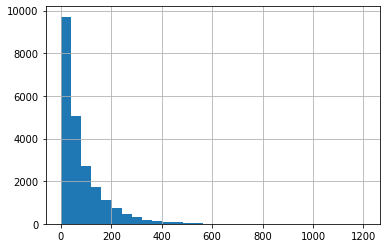

In [11]:
df_barplot = df_activity_sum[df_activity_sum['final_result']==0]
df_barplot = df_barplot.drop(['code_module', 'code_presentation', 'id_student', 'final_result'], axis=1)
df_barplot['Average'] = df_barplot.mean(axis=1)
print(df_barplot['Average'].mean(axis=0))
df_barplot['Average'].hist(bins=30)

15.697503938558459


<AxesSubplot:>

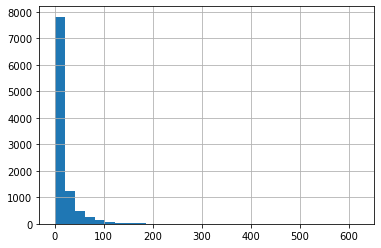

In [12]:
df_barplot = df_activity_sum[df_activity_sum['final_result']==1]
df_barplot = df_barplot.drop(['code_module', 'code_presentation', 'id_student', 'final_result'], axis=1)
df_barplot['Average'] = df_barplot.mean(axis=1)
print(df_barplot['Average'].mean(axis=0))
df_barplot['Average'].hist(bins=30)

In [13]:
df_activity_num = df_studentVle.drop(['date'], axis=1).merge(df_vle.drop(['week_from', 'week_to'], axis=1), how='left', on=['id_site', 'code_module', 'code_presentation'])
df_activity_num = df_activity_num.drop(['id_site'], axis=1)
df_activity_num = df_activity_num.groupby(['code_module', 'code_presentation', 'id_student', 'activity_type']).count()
df_activity_num = df_activity_num.reset_index()
df_activity_num = df_activity_num.rename(columns={'sum_click':'num_click'})
df_activity_num = df_activity_num.set_index(['code_module', 'code_presentation', 'id_student', 'activity_type']).unstack(['activity_type'])
df_activity_num.columns = ['{}_{}'.format(t, v) for v, t in df_activity_num.columns]
df_activity_num = df_activity_num.reset_index()
df_activity_num = df_activity_num.fillna(0)
df_activity_num = df_activity_num.merge(df_dropout, how='right', on=['code_module', 'code_presentation', 'id_student'])
df_activity_num = df_activity_num.fillna(0)
# DF sa brojem pristupa aktivnostima po aktivnostima za svakog studenta i predmete
df_activity_num

,code_module,code_presentation,id_student,dataplus_num_click,dualpane_num_click,externalquiz_num_click,folder_num_click,forumng_num_click,glossary_num_click,homepage_num_click,...,ouwiki_num_click,page_num_click,questionnaire_num_click,quiz_num_click,repeatactivity_num_click,resource_num_click,sharedsubpage_num_click,subpage_num_click,url_num_click,final_result
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,52.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,11.0,4.0,0
1,AAA,2013J,28400,3.0,0.0,0.0,0.0,163.0,0.0,80.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,42.0,27.0,0
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,30.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,12.0,4.0,1
3,AAA,2013J,31604,1.0,0.0,0.0,0.0,197.0,1.0,121.0,...,0.0,0.0,0.0,0.0,0.0,13.0,0.0,83.0,51.0,0
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,77.0,3.0,68.0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,53.0,13.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0
32589,GGG,2014J,2645731,0.0,0.0,0.0,0.0,14.0,2.0,35.0,...,0.0,0.0,0.0,38.0,0.0,67.0,0.0,20.0,0.0,0
32590,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,22.0,...,0.0,0.0,0.0,36.0,0.0,14.0,0.0,14.0,0.0,0
32591,GGG,2014J,2679821,0.0,0.0,0.0,0.0,17.0,0.0,13.0,...,0.0,0.0,0.0,5.0,0.0,9.0,0.0,6.0,0.0,1


21.614616481704346


<AxesSubplot:>

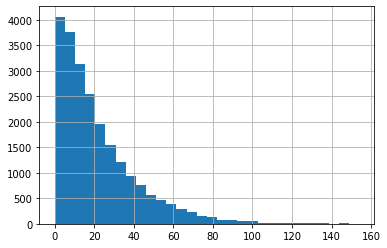

In [14]:
df_barplot = df_activity_num[df_activity_sum['final_result']==0]
df_barplot = df_barplot.drop(['code_module', 'code_presentation', 'id_student', 'final_result'], axis=1)
df_barplot['Average'] = df_barplot.mean(axis=1)
print(df_barplot['Average'].mean(axis=0))
df_barplot['Average'].hist(bins=30)

4.70626723119339


<AxesSubplot:>

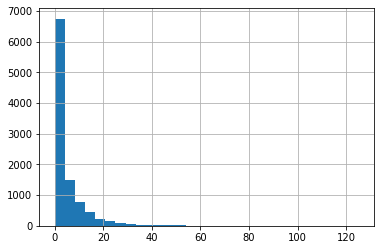

In [15]:
df_barplot = df_activity_num[df_activity_sum['final_result']==1]
df_barplot = df_barplot.drop(['code_module', 'code_presentation', 'id_student', 'final_result'], axis=1)
df_barplot['Average'] = df_barplot.mean(axis=1)
print(df_barplot['Average'].mean(axis=0))
df_barplot['Average'].hist(bins=30)

In [14]:
df_all = df_activity_num.merge(df_activity_sum, how='inner', on=['code_module', 'code_presentation', 'id_student', 'final_result'])
df_all = df_all.merge(df_stud_Assessment, how='inner', on=['code_module', 'code_presentation', 'id_student', 'final_result'])
df_all = df_all.merge(df_stud_demographic, how='inner', on=['code_module', 'code_presentation', 'id_student', 'final_result'])
df_all

,code_module,code_presentation,id_student,dataplus_num_click,dualpane_num_click,externalquiz_num_click,folder_num_click,forumng_num_click,glossary_num_click,homepage_num_click,...,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_35-55,age_band_55<=,disability_Y
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,52.0,0.0,40.0,...,0,0,0,0,0,0,1,0,1,0
1,AAA,2013J,28400,3.0,0.0,0.0,0.0,163.0,0.0,80.0,...,0,0,0,0,0,0,0,1,0,0
2,AAA,2013J,30268,0.0,0.0,0.0,0.0,30.0,0.0,12.0,...,1,0,0,0,0,0,0,1,0,1
3,AAA,2013J,31604,1.0,0.0,0.0,0.0,197.0,1.0,121.0,...,0,0,1,0,0,0,0,1,0,0
4,AAA,2013J,32885,0.0,0.0,0.0,0.0,77.0,3.0,68.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
32589,GGG,2014J,2645731,0.0,0.0,0.0,0.0,14.0,2.0,35.0,...,0,1,0,0,0,0,0,1,0,0
32590,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,22.0,...,0,0,0,0,0,0,0,0,0,1
32591,GGG,2014J,2679821,0.0,0.0,0.0,0.0,17.0,0.0,13.0,...,0,0,0,0,0,0,1,1,0,0


## Implementation

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

# Demographic data predicting dropout

In [19]:
# Mođda povecat n_estimators kod RFC
dem_RFC = []
dem_RFC_minmax = []
dem_RFC_standard = []
dem_GBM = []
dem_GBM_minmax = []
dem_GBM_standard = []
dem_LR = []
dem_LR_minmax = []
dem_LR_standard = []
X = df_stud_demographic[['num_of_prev_attempts','studied_credits','gender_M','region_East Midlands Region','region_Ireland','region_London Region','region_North Region','region_North Western Region','region_Scotland','region_South East Region','region_South Region','region_South West Region','region_Wales','region_West Midlands Region','region_Yorkshire Region','highest_education_HE Qualification','highest_education_Lower Than A Level','highest_education_No Formal quals','highest_education_Post Graduate Qualification','imd_band_10-20','imd_band_20-30%','imd_band_30-40%','imd_band_40-50%','imd_band_50-60%','imd_band_60-70%','imd_band_70-80%','imd_band_80-90%','imd_band_90-100%','age_band_35-55','age_band_55<=','disability_Y']].values
y = df_stud_demographic['final_result'].values

kf = KFold(n_splits=5)
kf.get_n_splits(X)
counter = 0
for train_index, test_index in kf.split(X):
    counter+= 1
    print(str(counter)+" Fold")
    scaler1 = MinMaxScaler()
    scaler2 = StandardScaler()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_minmax = scaler1.fit_transform(X_train)
    X_test_minmax = scaler1.transform(X_test)
    X_train_standard = scaler2.fit_transform(X_train)
    X_test_standard = scaler2.transform(X_test)
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    dem_RFC.append(clf1.score(X_test, y_test))
    dem_GBM.append(clf2.score(X_test, y_test))
    dem_LR.append(clf3.score(X_test, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_minmax, y_train)
    clf2.fit(X_train_minmax, y_train)
    clf3.fit(X_train_minmax, y_train)
    dem_RFC_minmax.append(clf1.score(X_test_minmax, y_test))
    dem_GBM_minmax.append(clf2.score(X_test_minmax, y_test))
    dem_LR_minmax.append(clf3.score(X_test_minmax, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_standard, y_train)
    clf2.fit(X_train_standard, y_train)
    clf3.fit(X_train_standard, y_train)
    dem_RFC_standard.append(clf1.score(X_test_standard, y_test))
    dem_GBM_standard.append(clf2.score(X_test_standard, y_test))
    dem_LR_standard.append(clf3.score(X_test_standard, y_test))

print("Avg 5-fold accuracy of RFC "+str(np.mean(np.array(dem_RFC))))
print("Avg 5-fold accuracy of GBM "+str(np.mean(np.array(dem_GBM))))
print("Avg 5-fold accuracy of LR "+str(np.mean(np.array(dem_LR))))

print("Avg 5-fold accuracy of RFC minmax "+str(np.mean(np.array(dem_RFC_minmax))))
print("Avg 5-fold accuracy of GBM minmax "+str(np.mean(np.array(dem_GBM_minmax))))
print("Avg 5-fold accuracy of LR minmax "+str(np.mean(np.array(dem_LR_minmax))))

print("Avg 5-fold accuracy of RFC standard "+str(np.mean(np.array(dem_RFC_standard))))
print("Avg 5-fold accuracy of GBM standard "+str(np.mean(np.array(dem_GBM_standard))))
print("Avg 5-fold accuracy of LR  standard "+str(np.mean(np.array(dem_LR_standard))))

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
Avg 5-fold accuracy of RFC 0.6340333006345226
Avg 5-fold accuracy of GBM 0.688125963707662
Avg 5-fold accuracy of LR 0.6932193906630515
Avg 5-fold accuracy of RFC minmax 0.6343091388963298
Avg 5-fold accuracy of GBM minmax 0.6881566479666372
Avg 5-fold accuracy of LR minmax 0.6930659740750724
Avg 5-fold accuracy of RFC standard 0.6352910540111207
Avg 5-fold accuracy of GBM standard 0.6880952841555834
Avg 5-fold accuracy of LR  standard 0.6931273143516432


# Assessment score to predict dropout

In [20]:
ase_RFC = []
ase_RFC_minmax = []
ase_RFC_standard = []
ase_GBM = []
ase_GBM_minmax = []
ase_GBM_standard = []
ase_LR = []
ase_LR_minmax = []
ase_LR_standard = []
X = df_stud_Assessment[['0_score', '1_score']].values
y = df_stud_Assessment['final_result'].values

kf = KFold(n_splits=5)
kf.get_n_splits(X)
counter = 0
for train_index, test_index in kf.split(X):
    counter+= 1
    print(str(counter)+" Fold")
    scaler1 = MinMaxScaler()
    scaler2 = StandardScaler()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_minmax = scaler1.fit_transform(X_train)
    X_test_minmax = scaler1.transform(X_test)
    X_train_standard = scaler2.fit_transform(X_train)
    X_test_standard = scaler2.transform(X_test)
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    ase_RFC.append(clf1.score(X_test, y_test))
    ase_GBM.append(clf2.score(X_test, y_test))
    ase_LR.append(clf3.score(X_test, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_minmax, y_train)
    clf2.fit(X_train_minmax, y_train)
    clf3.fit(X_train_minmax, y_train)
    ase_RFC_minmax.append(clf1.score(X_test_minmax, y_test))
    ase_GBM_minmax.append(clf2.score(X_test_minmax, y_test))
    ase_LR_minmax.append(clf3.score(X_test_minmax, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_standard, y_train)
    clf2.fit(X_train_standard, y_train)
    clf3.fit(X_train_standard, y_train)
    ase_RFC_standard.append(clf1.score(X_test_standard, y_test))
    ase_GBM_standard.append(clf2.score(X_test_standard, y_test))
    ase_LR_standard.append(clf3.score(X_test_standard, y_test))

print("Avg 5-fold accuracy of RFC "+str(np.mean(np.array(ase_RFC))))
print("Avg 5-fold accuracy of GBM "+str(np.mean(np.array(ase_GBM))))
print("Avg 5-fold accuracy of LR "+str(np.mean(np.array(ase_LR))))

print("Avg 5-fold accuracy of RFC minmax "+str(np.mean(np.array(ase_RFC_minmax))))
print("Avg 5-fold accuracy of GBM minmax "+str(np.mean(np.array(ase_GBM_minmax))))
print("Avg 5-fold accuracy of LR minmax "+str(np.mean(np.array(ase_LR_minmax))))

print("Avg 5-fold accuracy of RFC standard "+str(np.mean(np.array(ase_RFC_standard))))
print("Avg 5-fold accuracy of GBM standard "+str(np.mean(np.array(ase_GBM_standard))))
print("Avg 5-fold accuracy of LR  standard "+str(np.mean(np.array(ase_LR_standard))))

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
Avg 5-fold accuracy of RFC 0.7946498071278512
Avg 5-fold accuracy of GBM 0.8206678888594394
Avg 5-fold accuracy of LR 0.820790734153962
Avg 5-fold accuracy of RFC minmax 0.7956623782602378
Avg 5-fold accuracy of GBM minmax 0.8206678888594394
Avg 5-fold accuracy of LR minmax 0.8208827728101976
Avg 5-fold accuracy of RFC standard 0.7969511218440904
Avg 5-fold accuracy of GBM standard 0.8206678888594394
Avg 5-fold accuracy of LR  standard 0.820790734153962


# Activity sum vle predicting dropout

In [21]:
sum_RFC = []
sum_RFC_minmax = []
sum_RFC_standard = []
sum_GBM = []
sum_GBM_minmax = []
sum_GBM_standard = []
sum_LR = []
sum_LR_minmax = []
sum_LR_standard = []
X = df_activity_sum[['dataplus_sum_click','dualpane_sum_click','externalquiz_sum_click','folder_sum_click','forumng_sum_click','glossary_sum_click','homepage_sum_click','htmlactivity_sum_click','oucollaborate_sum_click','oucontent_sum_click','ouelluminate_sum_click','ouwiki_sum_click','page_sum_click','questionnaire_sum_click','quiz_sum_click','repeatactivity_sum_click','resource_sum_click','sharedsubpage_sum_click','subpage_sum_click','url_sum_click',]].values
y = df_activity_sum['final_result'].values

kf = KFold(n_splits=5)
kf.get_n_splits(X)
counter = 0
for train_index, test_index in kf.split(X):
    counter+= 1
    print(str(counter)+" Fold")
    scaler1 = MinMaxScaler()
    scaler2 = StandardScaler()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_minmax = scaler1.fit_transform(X_train)
    X_test_minmax = scaler1.transform(X_test)
    X_train_standard = scaler2.fit_transform(X_train)
    X_test_standard = scaler2.transform(X_test)
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    sum_RFC.append(clf1.score(X_test, y_test))
    sum_GBM.append(clf2.score(X_test, y_test))
    sum_LR.append(clf3.score(X_test, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_minmax, y_train)
    clf2.fit(X_train_minmax, y_train)
    clf3.fit(X_train_minmax, y_train)
    sum_RFC_minmax.append(clf1.score(X_test_minmax, y_test))
    sum_GBM_minmax.append(clf2.score(X_test_minmax, y_test))
    sum_LR_minmax.append(clf3.score(X_test_minmax, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_standard, y_train)
    clf2.fit(X_train_standard, y_train)
    clf3.fit(X_train_standard, y_train)
    sum_RFC_standard.append(clf1.score(X_test_standard, y_test))
    sum_GBM_standard.append(clf2.score(X_test_standard, y_test))
    sum_LR_standard.append(clf3.score(X_test_standard, y_test))

print("Avg 10-fold accuracy of RFC "+str(np.mean(np.array(sum_RFC))))
print("Avg 10-fold accuracy of GBM "+str(np.mean(np.array(sum_GBM))))
print("Avg 10-fold accuracy of LR "+str(np.mean(np.array(sum_LR))))

print("Avg 10-fold accuracy of RFC minmax "+str(np.mean(np.array(sum_RFC_minmax))))
print("Avg 10-fold accuracy of GBM minmax "+str(np.mean(np.array(sum_GBM_minmax))))
print("Avg 10-fold accuracy of LR minmax "+str(np.mean(np.array(sum_LR_minmax))))

print("Avg 10-fold accuracy of RFC standard "+str(np.mean(np.array(sum_RFC_standard))))
print("Avg 10-fold accuracy of GBM standard "+str(np.mean(np.array(sum_GBM_standard))))
print("Avg 10-fold accuracy of LR  standard "+str(np.mean(np.array(sum_LR_standard))))

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
Avg 10-fold accuracy of RFC 0.7412060697691046
Avg 10-fold accuracy of GBM 0.7351929528720567
Avg 10-fold accuracy of LR 0.7425252952153784
Avg 10-fold accuracy of RFC minmax 0.7406230970899566
Avg 10-fold accuracy of GBM minmax 0.7353770443052177
Avg 10-fold accuracy of LR minmax 0.7589694080432673
Avg 10-fold accuracy of RFC standard 0.7432616327066429
Avg 10-fold accuracy of GBM standard 0.7352543119762137
Avg 10-fold accuracy of LR  standard 0.742126465745254


# Activity count vle predicting dropout

In [22]:
num_RFC = []
num_RFC_minmax = []
num_RFC_standard = []
num_GBM = []
num_GBM_minmax = []
num_GBM_standard = []
num_LR = []
num_LR_minmax = []
num_LR_standard = []
X_num = df_activity_num[['dataplus_num_click','dualpane_num_click','externalquiz_num_click','folder_num_click','forumng_num_click','glossary_num_click','homepage_num_click','htmlactivity_num_click','oucollaborate_num_click','oucontent_num_click','ouelluminate_num_click','ouwiki_num_click','page_num_click','questionnaire_num_click','quiz_num_click','repeatactivity_num_click','resource_num_click','sharedsubpage_num_click','subpage_num_click','url_num_click']].values
y_num = df_activity_num['final_result'].values

kf = KFold(n_splits=5)
kf.get_n_splits(X_num)
counter = 0
for train_index, test_index in kf.split(X_num):
    counter+= 1
    print(str(counter)+" Fold")
    scaler1 = MinMaxScaler()
    scaler2 = StandardScaler()

    X_train, X_test = X_num[train_index], X_num[test_index]
    y_train, y_test = y_num[train_index], y_num[test_index]
    X_train_minmax = scaler1.fit_transform(X_train)
    X_test_minmax = scaler1.transform(X_test)
    X_train_standard = scaler2.fit_transform(X_train)
    X_test_standard = scaler2.transform(X_test)
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    num_RFC.append(clf1.score(X_test, y_test))
    num_GBM.append(clf2.score(X_test, y_test))
    num_LR.append(clf3.score(X_test, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_minmax, y_train)
    clf2.fit(X_train_minmax, y_train)
    clf3.fit(X_train_minmax, y_train)
    num_RFC_minmax.append(clf1.score(X_test_minmax, y_test))
    num_GBM_minmax.append(clf2.score(X_test_minmax, y_test))
    num_LR_minmax.append(clf3.score(X_test_minmax, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_standard, y_train)
    clf2.fit(X_train_standard, y_train)
    clf3.fit(X_train_standard, y_train)
    num_RFC_standard.append(clf1.score(X_test_standard, y_test))
    num_GBM_standard.append(clf2.score(X_test_standard, y_test))
    num_LR_standard.append(clf3.score(X_test_standard, y_test))

print("Avg 10-fold accuracy of RFC "+str(np.mean(np.array(num_RFC))))
print("Avg 10-fold accuracy of GBM "+str(np.mean(np.array(num_GBM))))
print("Avg 10-fold accuracy of LR "+str(np.mean(np.array(num_LR))))

print("Avg 10-fold accuracy of RFC minmax "+str(np.mean(np.array(num_RFC_minmax))))
print("Avg 10-fold accuracy of GBM minmax "+str(np.mean(np.array(num_GBM_minmax))))
print("Avg 10-fold accuracy of LR minmax "+str(np.mean(np.array(num_LR_minmax))))

print("Avg 10-fold accuracy of RFC standard "+str(np.mean(np.array(num_RFC_standard))))
print("Avg 10-fold accuracy of GBM standard "+str(np.mean(np.array(num_GBM_standard))))
print("Avg 10-fold accuracy of LR  standard "+str(np.mean(np.array(num_LR_standard))))

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
Avg 10-fold accuracy of RFC 0.7561773334592898
Avg 10-fold accuracy of GBM 0.746390575173822
Avg 10-fold accuracy of LR 0.77268403389135
Avg 10-fold accuracy of RFC minmax 0.7552571257590047
Avg 10-fold accuracy of GBM minmax 0.746482623243851
Avg 10-fold accuracy of LR minmax 0.786274694203518
Avg 10-fold accuracy of RFC standard 0.7556558140222309
Avg 10-fold accuracy of GBM standard 0.7464826185369543
Avg 10-fold accuracy of LR  standard 0.7732976390536106


# All features predicting dropout

In [23]:
all_RFC = []
all_RFC_minmax = []
all_RFC_standard = []
all_GBM = []
all_GBM_minmax = []
all_GBM_standard = []
all_LR = []
all_LR_minmax = []
all_LR_standard = []
X = df_all[['dataplus_num_click','dualpane_num_click','externalquiz_num_click','folder_num_click','forumng_num_click','glossary_num_click','homepage_num_click','htmlactivity_num_click','oucollaborate_num_click','oucontent_num_click','ouelluminate_num_click','ouwiki_num_click','page_num_click','questionnaire_num_click','quiz_num_click','repeatactivity_num_click','resource_num_click','sharedsubpage_num_click','subpage_num_click','url_num_click','dataplus_sum_click','dualpane_sum_click','externalquiz_sum_click','folder_sum_click','forumng_sum_click','glossary_sum_click','homepage_sum_click','htmlactivity_sum_click','oucollaborate_sum_click','oucontent_sum_click','ouelluminate_sum_click','ouwiki_sum_click','page_sum_click','questionnaire_sum_click','quiz_sum_click','repeatactivity_sum_click','resource_sum_click',
 'sharedsubpage_sum_click','subpage_sum_click','url_sum_click','0_score','1_score','num_of_prev_attempts','studied_credits','gender_M','region_East Midlands Region','region_Ireland','region_London Region','region_North Region','region_North Western Region','region_Scotland','region_South East Region','region_South Region','region_South West Region','region_Wales','region_West Midlands Region','region_Yorkshire Region','highest_education_HE Qualification','highest_education_Lower Than A Level','highest_education_No Formal quals','highest_education_Post Graduate Qualification','imd_band_10-20','imd_band_20-30%','imd_band_30-40%','imd_band_40-50%','imd_band_50-60%','imd_band_60-70%','imd_band_70-80%','imd_band_80-90%','imd_band_90-100%','age_band_35-55','age_band_55<=','disability_Y']].values
y = df_all['final_result'].values

kf = KFold(n_splits=5)
kf.get_n_splits(X)
counter = 0
for train_index, test_index in kf.split(X):
    counter+= 1
    print(str(counter)+" Fold")
    scaler1 = MinMaxScaler()
    scaler2 = StandardScaler()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_minmax = scaler1.fit_transform(X_train)
    X_test_minmax = scaler1.transform(X_test)
    X_train_standard = scaler2.fit_transform(X_train)
    X_test_standard = scaler2.transform(X_test)
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    all_RFC.append(clf1.score(X_test, y_test))
    all_GBM.append(clf2.score(X_test, y_test))
    all_LR.append(clf3.score(X_test, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_minmax, y_train)
    clf2.fit(X_train_minmax, y_train)
    clf3.fit(X_train_minmax, y_train)
    all_RFC_minmax.append(clf1.score(X_test_minmax, y_test))
    all_GBM_minmax.append(clf2.score(X_test_minmax, y_test))
    all_LR_minmax.append(clf3.score(X_test_minmax, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_standard, y_train)
    clf2.fit(X_train_standard, y_train)
    clf3.fit(X_train_standard, y_train)
    all_RFC_standard.append(clf1.score(X_test_standard, y_test))
    all_GBM_standard.append(clf2.score(X_test_standard, y_test))
    all_LR_standard.append(clf3.score(X_test_standard, y_test))

print("Avg 10-fold accuracy of RFC "+str(np.mean(np.array(all_RFC))))
print("Avg 10-fold accuracy of GBM "+str(np.mean(np.array(all_GBM))))
print("Avg 10-fold accuracy of LR "+str(np.mean(np.array(all_LR))))

print("Avg 10-fold accuracy of RFC minmax "+str(np.mean(np.array(all_RFC_minmax))))
print("Avg 10-fold accuracy of GBM minmax "+str(np.mean(np.array(all_GBM_minmax))))
print("Avg 10-fold accuracy of LR minmax "+str(np.mean(np.array(all_LR_minmax))))

print("Avg 10-fold accuracy of RFC standard "+str(np.mean(np.array(all_RFC_standard))))
print("Avg 10-fold accuracy of GBM standard "+str(np.mean(np.array(all_GBM_standard))))
print("Avg 10-fold accuracy of LR  standard "+str(np.mean(np.array(all_LR_standard))))

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
Avg 10-fold accuracy of RFC 0.7998366706877685
Avg 10-fold accuracy of GBM 0.8198400963671183
Avg 10-fold accuracy of LR 0.8139182744366421
Avg 10-fold accuracy of RFC minmax 0.8070771673576156
Avg 10-fold accuracy of GBM minmax 0.8199014554712754
Avg 10-fold accuracy of LR minmax 0.8191951950493237
Avg 10-fold accuracy of RFC standard 0.8012172081692333
Avg 10-fold accuracy of GBM standard 0.8198707759191969
Avg 10-fold accuracy of LR  standard 0.8105125617421278


# Prediction of success based on demographics and previous education

## Classifiers

In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier


def klasifikacija(X, y, model):
    
    scores_accuracy = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    scores_precision = cross_val_score(model, X, y, cv=5, scoring="precision")
    scores_recall = cross_val_score(model, X, y, cv=5, scoring="recall")
    scores_f1 = cross_val_score(model, X, y, cv=5, scoring="f1")
    
    return scores_accuracy.mean(), scores_precision.mean(), scores_recall.mean(), scores_f1.mean()
    
    

def DecisionTreeKlasifikator(X, y):
    return klasifikacija(X, y, DecisionTreeClassifier(random_state=42))

def RandomForestKlasifikator(X, y):
    return klasifikacija(X, y, RandomForestClassifier(random_state=42))

def LogisticRegressionKlasifikator(X, y):
    return klasifikacija(X, y, LogisticRegression(max_iter=2000))

def NaiveBayes(X, y):
    return klasifikacija(X, y, GaussianNB())

def KNN(X, y):
    return klasifikacija(X, y, KNeighborsClassifier(n_neighbors=50))

## Preprocessing

In [3]:
# Loading data
df_assessments = pd.read_csv('assessments.csv')
df_courses = pd.read_csv('courses.csv')
df_studentAssessment = pd.read_csv('studentAssessment.csv')
df_studentInfo = pd.read_csv('studentInfo.csv')
df_studentRegistration = pd.read_csv('studentRegistration.csv')
df_studentVle = pd.read_csv('studentVle.csv')
df_vle = pd.read_csv('vle.csv')

In [4]:
df_studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [5]:
df_studentInfo.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [6]:
df_studentInfo = df_studentInfo.loc[df_studentInfo.imd_band.notnull(), :]
df_studentInfo.isna().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64

In [9]:
df_studentInfo["final_result"].replace({"Pass" : 1, "Fail" : 0, "Distinction" : 1, "Withdrawn" : 0}, inplace=True)
df_studentInfo_demographics = df_studentInfo.drop(["code_module", "code_presentation", "id_student", "region", "num_of_prev_attempts", "studied_credits", "disability"], axis=1)
df_studentInfo_demographics.reset_index(drop=True, inplace=True)
df_studentInfo_demographics

,gender,highest_education,imd_band,age_band,final_result
0,M,HE Qualification,90-100%,55<=,1
1,F,HE Qualification,20-30%,35-55,1
2,F,A Level or Equivalent,30-40%,35-55,0
3,F,A Level or Equivalent,50-60%,35-55,1
4,F,Lower Than A Level,50-60%,0-35,1
...,...,...,...,...,...
31477,F,Lower Than A Level,10-20,0-35,0
31478,F,Lower Than A Level,40-50%,35-55,1
31479,F,A Level or Equivalent,20-30%,0-35,1
31480,F,Lower Than A Level,90-100%,35-55,0


In [10]:
df_studentInfo_demographics = pd.get_dummies(df_studentInfo_demographics, columns=["age_band", "highest_education", "imd_band"], drop_first=True)
df_studentInfo_demographics.reset_index(drop=True, inplace=True)
df_studentInfo_demographics

,gender,final_result,age_band_35-55,age_band_55<=,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%
0,M,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,F,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,F,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,F,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,F,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31477,F,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
31478,F,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
31479,F,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
31480,F,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [11]:
df_studentInfo_demographics["gender"].replace({"M" : 1, "F" : 0}, inplace=True)
df_studentInfo_demographics.reset_index(drop=True, inplace=True)
df_studentInfo_demographics

,gender,final_result,age_band_35-55,age_band_55<=,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,imd_band_10-20,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%
0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31477,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
31478,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
31479,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
31480,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


## Classification

In [12]:
y = df_studentInfo_demographics["final_result"]
X = df_studentInfo_demographics.drop(["final_result"], axis=1)

In [13]:
acc, prec, recall, f1 = DecisionTreeKlasifikator(X, y)

In [14]:
print("Decision tree: F1={0} Precision={1}, Recall={2}, Accuracy={3}".format(f1, prec, recall, acc))

Decision tree: F1=0.49302845221744623 Precision=0.5555883141389073, Recall=0.4483793926987376, Accuracy=0.5750266105620171


In [15]:
acc, prec, recall, f1 = RandomForestKlasifikator(X, y)

In [16]:
print("Random forest: F1={0}, Precision={1}, Recall={2}, Accuracy={3}".format(f1, prec, recall, acc))

Random forest: F1=0.4905272082691172, Precision=0.5541308936394518, Recall=0.44544524053224155, Accuracy=0.5741054008292205


In [17]:
acc, prec, recall, f1 = LogisticRegressionKlasifikator(X, y)

In [18]:
print("Logistic regression: F1={0}, Precision={1}, Recall={2}, Accuracy={3}".format(f1, prec, recall, acc))

Logistic regression: F1=0.5018449624327403, Precision=0.5592783764824049, Recall=0.4610713067212556, Accuracy=0.5801399347302187


In [19]:
acc, prec, recall, f1 = NaiveBayes(X, y)

In [20]:
print("Naive Bayes: F1={0}, Precision={1}, Recall={2}, Accuracy={3}".format(f1, prec, recall, acc))

Naive Bayes: F1=0.488697717234906, Precision=0.5466454150613538, Recall=0.44517229614466053, Accuracy=0.5692140617171324


# Prediction of getting a score above 80 based on activity

## Preprocessing

In [16]:
df_above80 = df_studentAssessment[['id_assessment', 'id_student', 'score']]
df_above80['score'] = df_above80['score'].apply(lambda x : 1 if x > 80 else 0)
df_above80

,id_assessment,id_student,score
0,1752,11391,0
1,1752,28400,0
2,1752,31604,0
3,1752,32885,0
4,1752,38053,0
...,...,...,...
173907,37443,527538,0
173908,37443,534672,1
173909,37443,546286,0
173910,37443,546724,1


In [17]:
df_above80=df_above80[['id_student', 'score']]
df_above80

,id_student,score
0,11391,0
1,28400,0
2,31604,0
3,32885,0
4,38053,0
...,...,...
173907,527538,0
173908,534672,1
173909,546286,0
173910,546724,1


In [18]:
df_all_score = df_all.merge(df_above80, on=['id_student'], how='inner')
df_all_score = df_all_score.drop_duplicates()
df_all_score

,code_module,code_presentation,id_student,dataplus_num_click,dualpane_num_click,externalquiz_num_click,folder_num_click,forumng_num_click,glossary_num_click,homepage_num_click,...,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_35-55,age_band_55<=,disability_Y,score
0,AAA,2013J,11391,0.0,0.0,0.0,0.0,52.0,0.0,40.0,...,0,0,0,0,0,1,0,1,0,0
1,AAA,2013J,11391,0.0,0.0,0.0,0.0,52.0,0.0,40.0,...,0,0,0,0,0,1,0,1,0,1
5,AAA,2013J,28400,3.0,0.0,0.0,0.0,163.0,0.0,80.0,...,0,0,0,0,0,0,1,0,0,0
10,AAA,2013J,31604,1.0,0.0,0.0,0.0,197.0,1.0,121.0,...,0,1,0,0,0,0,1,0,0,0
13,AAA,2013J,31604,1.0,0.0,0.0,0.0,197.0,1.0,121.0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207301,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,22.0,...,0,0,0,0,0,0,0,0,1,0
207307,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,22.0,...,0,0,0,0,0,0,0,0,1,1
207310,GGG,2014J,2679821,0.0,0.0,0.0,0.0,17.0,0.0,13.0,...,0,0,0,0,0,1,1,0,0,1
207312,GGG,2014J,2684003,0.0,0.0,0.0,0.0,52.0,0.0,34.0,...,0,1,0,0,0,0,1,0,0,0


In [20]:
df_all_score=df_all_score.drop_duplicates(subset='id_student', keep="last")
df_all_score=df_all_score.sort_values('code_module', ascending=False).drop_duplicates('id_student').sort_index()
df_all_score

,code_module,code_presentation,id_student,dataplus_num_click,dualpane_num_click,externalquiz_num_click,folder_num_click,forumng_num_click,glossary_num_click,homepage_num_click,...,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_35-55,age_band_55<=,disability_Y,score
1,AAA,2013J,11391,0.0,0.0,0.0,0.0,52.0,0.0,40.0,...,0,0,0,0,0,1,0,1,0,1
5,AAA,2013J,28400,3.0,0.0,0.0,0.0,163.0,0.0,80.0,...,0,0,0,0,0,0,1,0,0,0
13,AAA,2013J,31604,1.0,0.0,0.0,0.0,197.0,1.0,121.0,...,0,1,0,0,0,0,1,0,0,1
15,AAA,2013J,32885,0.0,0.0,0.0,0.0,77.0,3.0,68.0,...,0,1,0,0,0,0,0,0,0,0
20,AAA,2013J,38053,1.0,0.0,0.0,0.0,286.0,2.0,142.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207284,GGG,2014J,2620947,0.0,0.0,0.0,0.0,7.0,1.0,35.0,...,0,0,0,0,1,0,0,0,1,1
207293,GGG,2014J,2645731,0.0,0.0,0.0,0.0,14.0,2.0,35.0,...,1,0,0,0,0,0,1,0,0,1
207307,GGG,2014J,2648187,0.0,0.0,0.0,0.0,0.0,1.0,22.0,...,0,0,0,0,0,0,0,0,1,1
207310,GGG,2014J,2679821,0.0,0.0,0.0,0.0,17.0,0.0,13.0,...,0,0,0,0,0,1,1,0,0,1


In [23]:
print("Getting a grade above 80: "+str(round(len(df_above80[df_above80['score'] == 1])/len(df_above80), 5)))
print("Our model needs to have accuracy > "+str(1-0.3116))

Getting a grade above 80: 0.43448
Our model needs to have accuracy > 0.6884


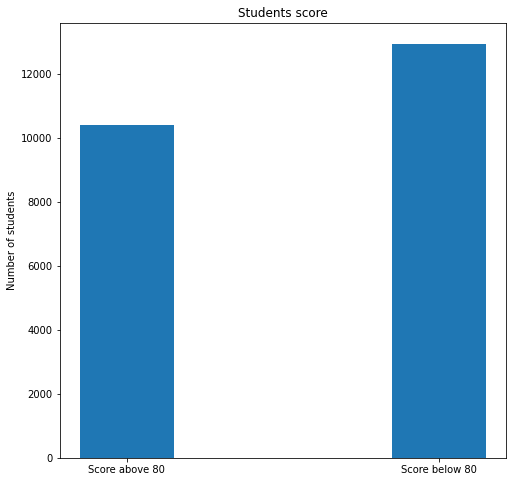

In [24]:
graph_data = {'Score above 80':len(df_all_score[df_all_score['score'] == 1]), 'Score below 80':len(df_all_score[df_all_score['score'] == 0])}
graph_data
fig = plt.figure(figsize=(8, 8))
plt.bar(list(graph_data.keys()), list(graph_data.values()), width=0.3)
plt.ylabel("Number of students")
plt.title("Students score")
plt.show()

In [27]:
print(len(df_all_score[df_all_score['score'] == 0]))
print(len(df_all_score[df_all_score['score'] == 1]))

12952
10417


In [28]:
df_all_score.isna().sum()

code_module           0
code_presentation     0
id_student            0
dataplus_num_click    0
dualpane_num_click    0
                     ..
imd_band_90-100%      0
age_band_35-55        0
age_band_55<=         0
disability_Y          0
score                 0
Length: 78, dtype: int64

In [29]:
sum_RFC = []
sum_RFC_minmax = []
sum_RFC_standard = []
sum_GBM = []
sum_GBM_minmax = []
sum_GBM_standard = []
sum_LR = []
sum_LR_minmax = []
sum_LR_standard = []
X = df_all_score[['dataplus_sum_click','dualpane_sum_click','externalquiz_sum_click','folder_sum_click','forumng_sum_click','glossary_sum_click','homepage_sum_click','imd_band_40-50%', 'imd_band_40-50%',
                 'imd_band_50-60%','imd_band_60-70%','imd_band_70-80%','imd_band_80-90%','imd_band_90-100%','age_band_35-55','age_band_55<=','disability_Y']].values
y = df_all_score['score'].values

kf = KFold(n_splits=5)
kf.get_n_splits(X)
counter = 0
for train_index, test_index in kf.split(X):
    counter+= 1
    print(str(counter)+" Fold")
    scaler1 = MinMaxScaler()
    scaler2 = StandardScaler()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_minmax = scaler1.fit_transform(X_train)
    X_test_minmax = scaler1.transform(X_test)
    X_train_standard = scaler2.fit_transform(X_train)
    X_test_standard = scaler2.transform(X_test)
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    sum_RFC.append(clf1.score(X_test, y_test))
    sum_GBM.append(clf2.score(X_test, y_test))
    sum_LR.append(clf3.score(X_test, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_minmax, y_train)
    clf2.fit(X_train_minmax, y_train)
    clf3.fit(X_train_minmax, y_train)
    sum_RFC_minmax.append(clf1.score(X_test_minmax, y_test))
    sum_GBM_minmax.append(clf2.score(X_test_minmax, y_test))
    sum_LR_minmax.append(clf3.score(X_test_minmax, y_test))
    
    clf1 = RandomForestClassifier()
    clf2 = GradientBoostingClassifier(n_estimators = 500, learning_rate=0.1, max_depth=3, random_state=1)
    clf3 = LogisticRegression(max_iter=1000)
    clf1.fit(X_train_standard, y_train)
    clf2.fit(X_train_standard, y_train)
    clf3.fit(X_train_standard, y_train)
    sum_RFC_standard.append(clf1.score(X_test_standard, y_test))
    sum_GBM_standard.append(clf2.score(X_test_standard, y_test))
    sum_LR_standard.append(clf3.score(X_test_standard, y_test))

print("Avg 10-fold accuracy of RFC "+str(np.mean(np.array(sum_RFC))))
print("Avg 10-fold accuracy of GBM "+str(np.mean(np.array(sum_GBM))))
print("Avg 10-fold accuracy of LR "+str(np.mean(np.array(sum_LR))))

print("Avg 10-fold accuracy of RFC minmax "+str(np.mean(np.array(sum_RFC_minmax))))
print("Avg 10-fold accuracy of GBM minmax "+str(np.mean(np.array(sum_GBM_minmax))))
print("Avg 10-fold accuracy of LR minmax "+str(np.mean(np.array(sum_LR_minmax))))

print("Avg 10-fold accuracy of RFC standard "+str(np.mean(np.array(sum_RFC_standard))))
print("Avg 10-fold accuracy of GBM standard "+str(np.mean(np.array(sum_GBM_standard))))
print("Avg 10-fold accuracy of LR  standard "+str(np.mean(np.array(sum_LR_standard))))

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold
Avg 10-fold accuracy of RFC 0.506781059374674
Avg 10-fold accuracy of GBM 0.5170075528342656
Avg 10-fold accuracy of LR 0.5493567275880222
Avg 10-fold accuracy of RFC minmax 0.5077222815432678
Avg 10-fold accuracy of GBM minmax 0.5169647446190073
Avg 10-fold accuracy of LR minmax 0.5499556946418125
Avg 10-fold accuracy of RFC standard 0.5069521640399821
Avg 10-fold accuracy of GBM standard 0.5169647629326823
Avg 10-fold accuracy of LR  standard 0.5488859471022318
